In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from cycler import cycler

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()
plt.style.use("fivethirtyeight")
plt.rcParams['text.color'] = 'black'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'

In [8]:
colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c',
          '#aec7e8', '#69B0AC']
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

## Read Data

In [9]:
nba_df = pd.read_csv('nba_cleaned.csv')
euro_df = pd.read_csv('euro_cleaned.csv')

In [10]:
nba_cluster_dict = {1: 'Ballhandler (Iso)', 0: 'Ballhandler',
                    2: 'Big', 7: 'Big', 3: 'Big',
                    6: 'Wing', 4: 'Wing', 5: 'Wing'}
nba_cluster_order = [1, 0, 6, 4, 5, 3, 2, 7]

In [11]:
euro_cluster_dict = {0: 'Ballhandler (Iso)', 7: 'Ballhandler', 1: 'Ballhandler',
                     6: 'Big', 3: 'Big', 4: 'Big',
                     2: 'Wing', 5: 'Wing'}
euro_cluster_order = [0, 7, 1, 5, 2, 4, 6, 3]

In [12]:
nba_clustering_models = load_pickle('nba_clustering_models')
nba_clustering_models.keys()

dict_keys(['pre_pca_pipe', 'pca', 'pre_cluster_scaler', 'cluster_dict'])

## Functions

In [13]:
def color_cluster(val, cluster_dict):
    if cluster_dict[val] == 'Ballhandler':
        return '#AB3B3A'
    elif cluster_dict[val] == 'Wing':
        return '#2E5C6E'
    elif cluster_dict[val] == 'Big':
        return '#F7D94C'

## Viz

Ticket 1

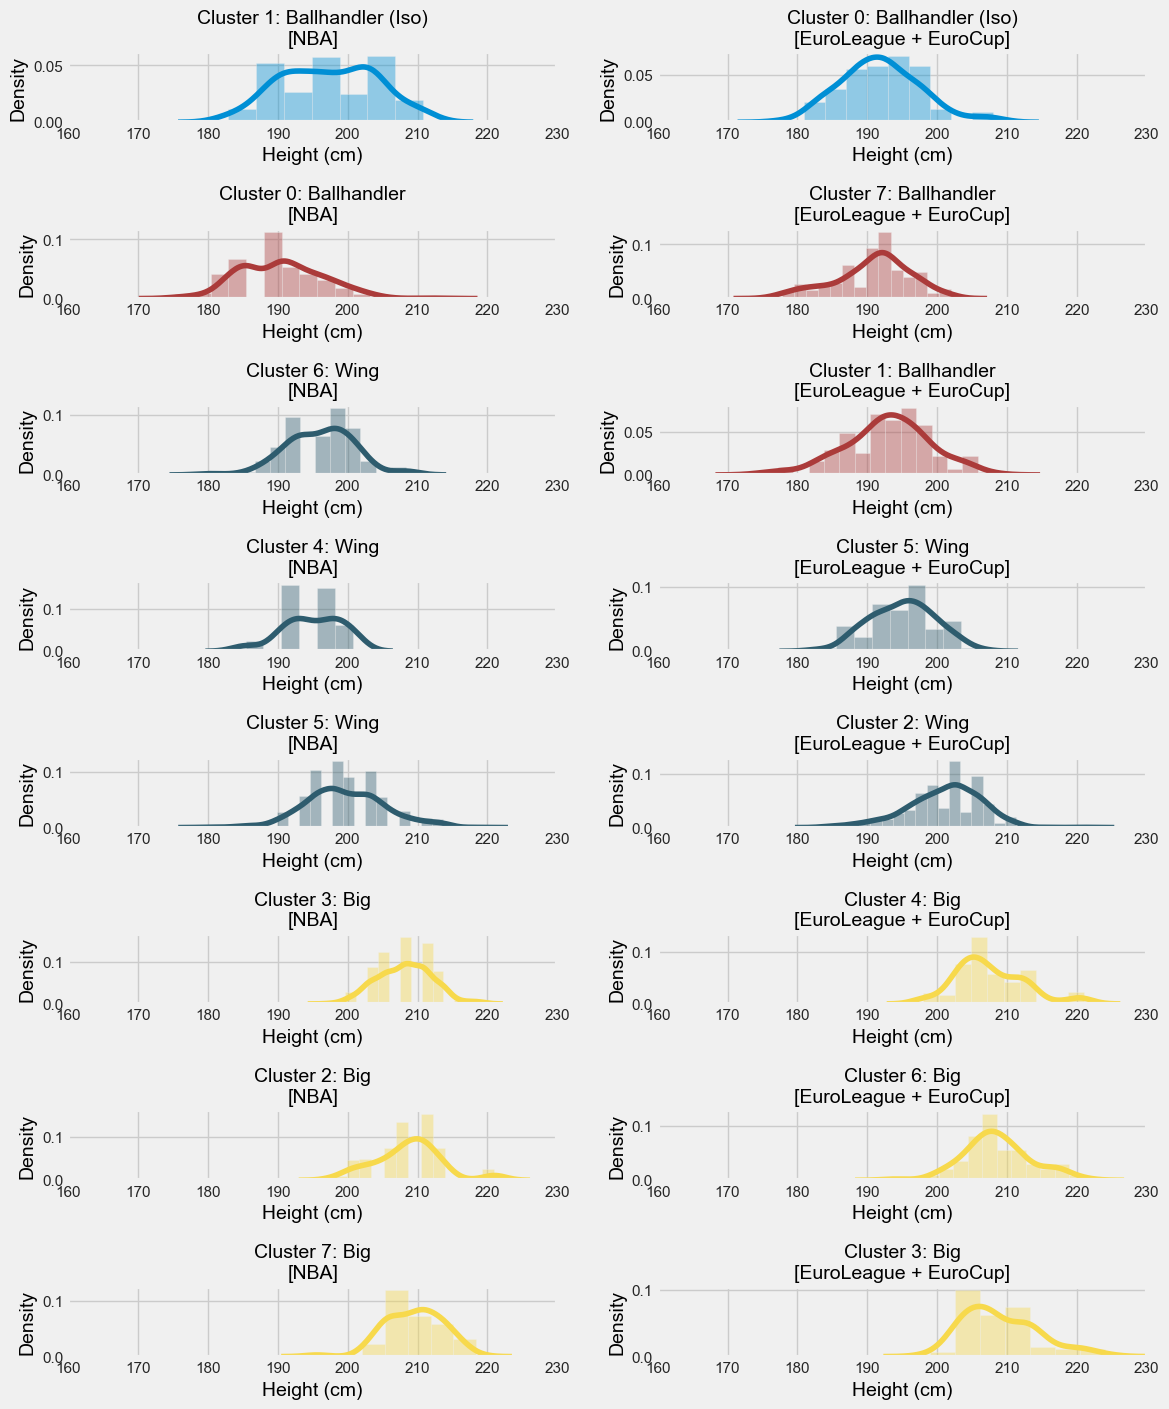

In [14]:
figsize(12, 28)
n_clusters = 8
for idx in range(n_clusters):
    cluster = nba_cluster_order[idx]
    color = color_cluster(cluster, nba_cluster_dict)
    plt.subplot(n_clusters*2, 2, idx*2+1)
    sns.distplot(nba_df[nba_df['player_cluster'] == cluster]['height_cm'],
                 color=color)
    plt.title(f'Cluster {cluster}: {nba_cluster_dict[cluster]}\n[NBA]')
    plt.xlabel('Height (cm)')
    plt.xlim(160, 230)
    
    plt.subplot(n_clusters*2, 2, idx*2+2)
    cluster = euro_cluster_order[idx]
    color = color_cluster(cluster, euro_cluster_dict)
    sns.distplot(euro_df[euro_df['player_cluster'] == cluster]['Height'],
                 color=color)
    plt.title(f'Cluster {cluster}: {euro_cluster_dict[cluster]}\n[EuroLeague + EuroCup]')
    plt.xlabel('Height (cm)')
    plt.xlim(160, 230)
    
plt.tight_layout()

Ticket 2

In [15]:
labels = nba_df['player_cluster'].values

In [16]:
weights = ['Isolation_Poss%',
 'P&R Ball Handler_Poss%',
 'Post-Up_Poss%',
 'P&R Roll Man_Poss%',
 'Spot Up_Poss%',
 'Off Screen_Poss%',
 'Hand Off_Poss%',
 'Cut_Poss%',
 'Offensive Rebounds_Poss%',
 'Transition_Poss%',
 'Catch and Shoot_FGA%',
 'At Rim_FGA%',
 'Long (3 point jump shots)_FGA%',
 'All Jump Shots off the Dribble_FGA%',
 'Pick and Rolls Including Passes_On_Court%',
 'Isolations Including Passes_On_Court%',
 'Post-Ups Including Passes_On_Court%']

In [17]:
X = nba_df[weights].copy()
X_transformed = X.copy()
queues = ['pre_pca_pipe', 'pca', 'pre_cluster_scaler']
for step in queues:
    X_transformed = nba_clustering_models[step].transform(X_transformed)

In [18]:
perplexity = 20
tsne = TSNE(perplexity=perplexity, 
#             early_exaggeration=4,
            init='random',
            random_state=42)
X_tsne = tsne.fit_transform(X_transformed)

In [19]:
def plot_players(lookup_idx, 
                 labels=labels, 
                 X_tsne=X_tsne, 
                 df=nba_df, 
                 cluster_dict=nba_cluster_dict):
    n_clusters = len(set(labels))
    for i in range(n_clusters):
        cluster_index = [j for j in range(len(labels)) if labels[j] == i]
        plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                    label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
    plt.legend()
    plt.title(f'TSNE Visualization (Spectral Clustering based on {n_clusters} PCA features)')
    for idx in lookup_idx:
        player_coord = X_tsne[idx]
        plt.scatter(player_coord[0], player_coord[1], marker='x', color='black')
        plt.annotate(f"{df.loc[idx]['Player']} {df.loc[idx]['Season']} {df.loc[idx]['Team']}", 
                     player_coord, alpha=0.6)

In [20]:
lookup_players = ['Stephen Curry', 'Klay Thompson', 'Jordan Poole']
lookup_idx = nba_df[nba_df['Player'].isin(lookup_players)].index

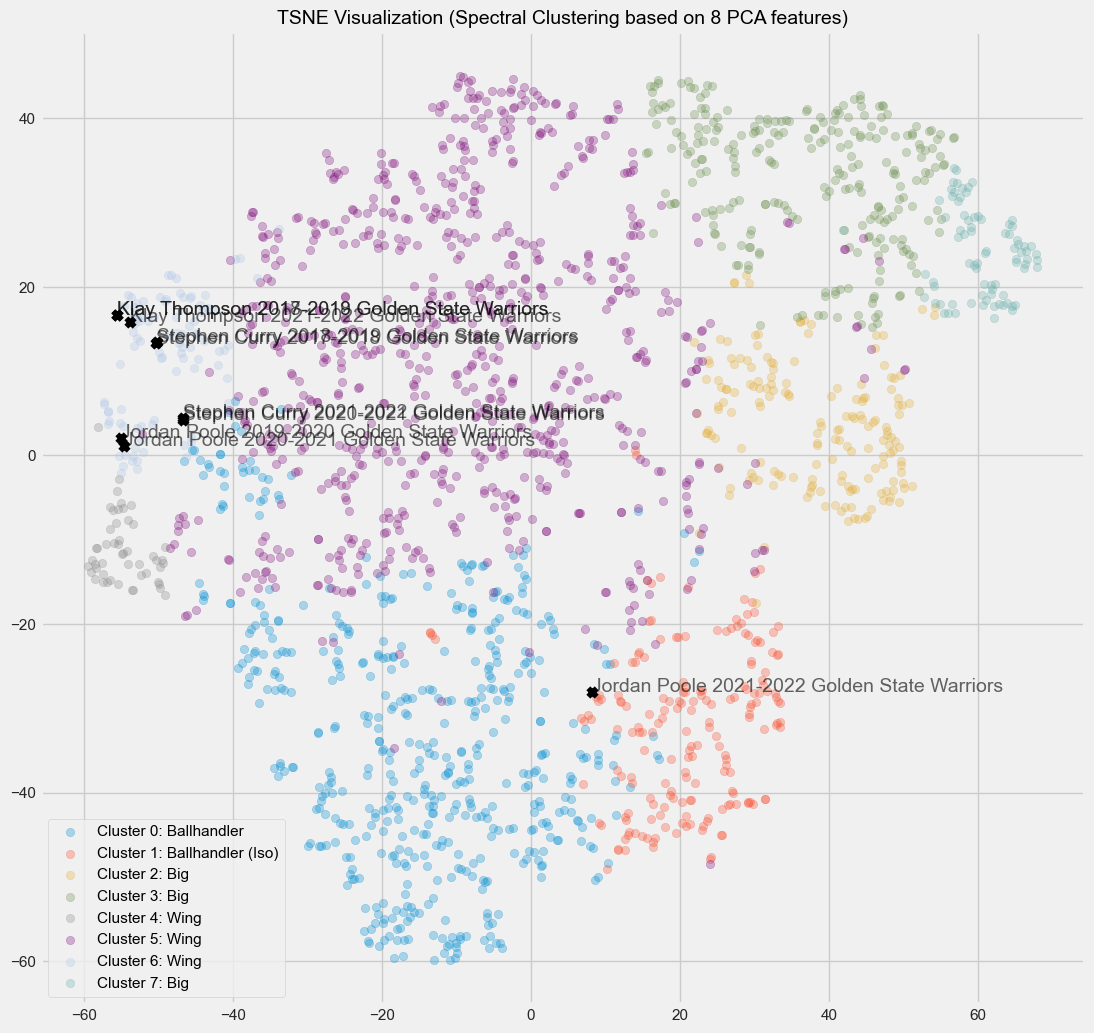

In [21]:
figsize(12, 12)
plot_players(lookup_idx)

In [22]:
lookup_players = ['Bruce Brown']
lookup_idx = nba_df[nba_df['Player'].isin(lookup_players)].index

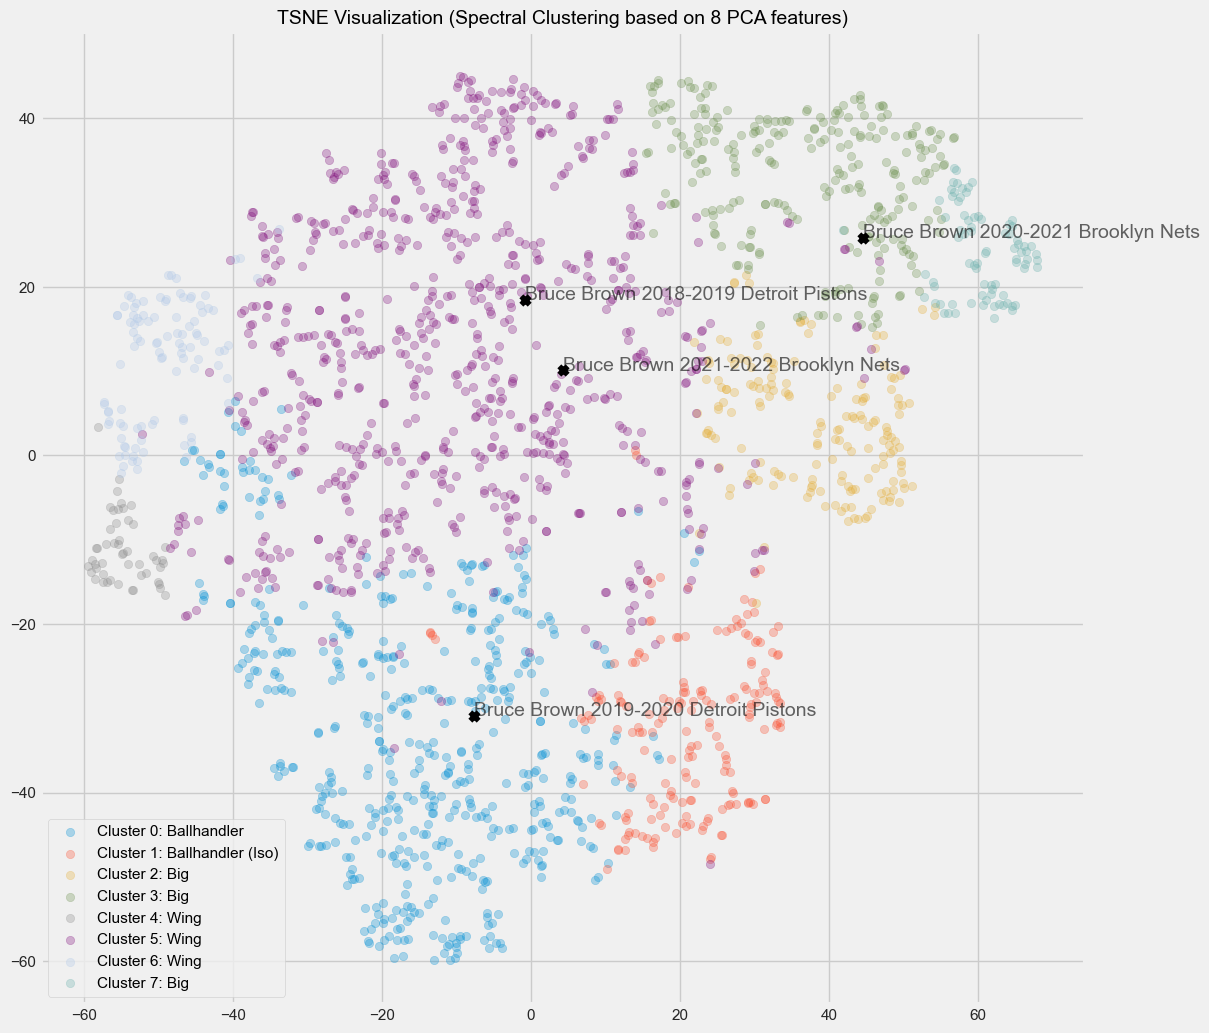

In [23]:
figsize(12, 12)
plot_players(lookup_idx)